In [69]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import unidecode
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
data = pd.read_csv('../csv/vagalume.csv')
data['genre'].unique()

array(['axe', 'gospel', 'rock', 'pop', 'sertanejo', 'samba', 'mpb',
       'funk-carioca', 'pagode', 'forro', 'infantil', 'bossa-nova',
       'jovem-guarda', 'velha-guarda'], dtype=object)

In [72]:
def proccess_text(text):
    # clear HTML tags
    new_text = BeautifulSoup(str(text), 'html').get_text()
    # clear portuguese accents
    new_text = unidecode.unidecode(new_text)
    # to lower
    new_text = str(new_text).lower()
    # removing non-lether characters
    new_text = re.sub('\\d+x', ' ', new_text)
    new_text = re.sub('[^a-z]', ' ', new_text)
    # tokenization via NLTK
    tokenized_text = word_tokenize(new_text, language='portuguese')
    # removing stopwords via NLTK
    stops = list(map(unidecode.unidecode, nltk.corpus.stopwords.words('portuguese')))
    tokens = [t for t in tokenized_text if t not in stops]
    
    return ' '.join(tokens)

In [74]:
# Processar todas as letras
data['cleaned_lyric'] = data['music_lyric'].apply(proccess_text)

# Juntar letras por gênero
grouped_lyrics = data.groupby('genre')['cleaned_lyric'].apply(' '.join).reset_index()

# Calcular TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(grouped_lyrics['cleaned_lyric'])
feature_names = vectorizer.get_feature_names_out()

# Criar DataFrame para TF-IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=grouped_lyrics['genre'])

C:\Users\Davi\AppData\Local\Temp\ipykernel_111604\3309774863.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  new_text = BeautifulSoup(str(text), 'html').get_text()


In [76]:
# Obter as palavras mais relevantes para cada gênero e salvar em um novo DataFrame
top_n = 100000  # Defina quantas palavras você quer ver
top_words = pd.DataFrame()

for genre in tfidf_df.index:
    
    # Obter as top_n palavras para o gênero atual
    top_n_words = tfidf_df.loc[genre].nlargest(top_n)
    
    # Criar DataFrame para as palavras
    top_n_words_df = pd.DataFrame(top_n_words).reset_index()
    
    # Adiciona um nome a coluna
    top_n_words_df.columns = ['palavra', 'tfidf_score']
    
    # Adicionar a coluna de gênero
    top_n_words_df['genero'] = genre  
    
    # Concatenar ao DataFrame principal
    top_words = pd.concat([top_words, top_n_words_df], ignore_index=True)
    print(top_words)

# Salvar resultados em um arquivo CSV
#top_words.to_csv('total.csv', index=True)

#print("Resultados salvos em 'total.csv'.")

      palavra  tfidf_score genero
0         pra     0.476140    axe
1        amor     0.325796    axe
2         vai     0.295821    axe
3         vou     0.270453    axe
4         vem     0.220286    axe
...       ...          ...    ...
99995     qls     0.000000    axe
99996      qm     0.000000    axe
99997     qnd     0.000000    axe
99998    qndo     0.000000    axe
99999     qnq     0.000000    axe

[100000 rows x 3 columns]
           palavra  tfidf_score      genero
0              pra     0.476140         axe
1             amor     0.325796         axe
2              vai     0.295821         axe
3              vou     0.270453         axe
4              vem     0.220286         axe
...            ...          ...         ...
199995   quebrante     0.000000  bossa-nova
199996  quebrantou     0.000000  bossa-nova
199997     quebrao     0.000000  bossa-nova
199998    quebrara     0.000000  bossa-nova
199999   quebrarao     0.000000  bossa-nova

[200000 rows x 3 columns]
          

In [77]:
# Pivotar o DataFrame para obter uma tabela de palavras por gênero
top_words_pivot = top_words.pivot(index='palavra', columns='genero', values='tfidf_score')

# Identificar todas as palavras únicas em cada gênero
unique_words_by_genre = {genre: set(top_words_pivot[genre].dropna().index) for genre in top_words_pivot.columns}

# Criar um DataFrame para armazenar palavras exclusivas
exclusive_words_df = pd.DataFrame(columns=['genero', 'palavras_exclusivas'])

# Comparar listas de palavras entre os gêneros
for genre in unique_words_by_genre:
    exclusive_words = unique_words_by_genre[genre].copy()  # Copia as palavras exclusivas
    for other_genre in unique_words_by_genre:
        if genre != other_genre:
            exclusive_words -= unique_words_by_genre[other_genre]  # Remove palavras que se repetem de outros gêneros
    
    # Adicionar as palavras exclusivas ao DataFrame usando pd.concat
    if exclusive_words:  # Verifica se há palavras exclusivas
        exclusive_words_df = pd.concat([
            exclusive_words_df,
            pd.DataFrame({'genero': genre, 'palavras_exclusivas': list(exclusive_words)})
        ], ignore_index=True)
    
print(exclusive_words_df)

# Salvar resultados em um arquivo CSV
#exclusive_words_df.to_csv('exclusive_words_by_genre.csv', index=False)

#print("Resultados salvos em 'exclusive_words_by_genre.csv'.")

             genero palavras_exclusivas
0               axe        solteirinhas
1               axe            separate
2               axe             ulelele
3               axe            siiiiiim
4               axe              uuoooo
...             ...                 ...
14588  velha-guarda            tamborin
14589  velha-guarda                ttao
14590  velha-guarda             taduzia
14591  velha-guarda               vrica
14592  velha-guarda             resedir

[14593 rows x 2 columns]


In [78]:
lyrics = exclusive_words_df[exclusive_words_df['genero'] == 'forro']
lyrics_list = lyrics['palavras_exclusivas'].apply(proccess_text).to_list()

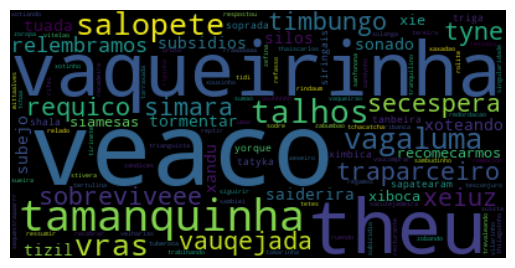

In [79]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(lyrics_list))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()